# SCNIEC+

This notebook runs the SCENIC+ framework for unpaired scRNA-seq and scATAC-seq on the tumor cells from the Spermatogenesis Mouse dataset 

In [1]:
#supress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import sys
import os
sys.path.append('/home/sussmanj/miniconda3/envs/scenicplus/lib/')
_stderr = sys.stderr
null = open(os.devnull,'wb')

%matplotlib inline

In [2]:
import importlib
import sys
import os 
import scanpy as sc
from scipy.io import mmread
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from scenicplus.scenicplus_class import SCENICPLUS, create_SCENICPLUS_object
from scenicplus.loom import *
from scenicplus.preprocessing.filtering import *
from pycisTopic.cistopic_class import *
from pycisTopic.lda_models import evaluate_models
from pycisTopic.clust_vis import run_umap
from loomxpy.loomxpy import SCopeLoom
from pycisTopic.loom import *
import itertools
import anndata
import pickle
import dill
from pycisTopic.clust_vis import *
from pycisTopic.topic_binarization import *
from pycisTopic.diff_features import *
from pycisTopic.lda_models import run_cgs_models_mallet
import scipy.sparse as sp
import scipy.io as spio
import pyranges as pr
import numpy as  np
from pycistarget.utils import region_names_to_coordinates
from pycisTopic.lda_models import run_cgs_models
from scenicplus.wrappers.run_pycistarget import run_pycistarget
import pybiomart as pbm
from scenicplus.preprocessing.filtering import apply_std_filtering_to_eRegulons
from scenicplus.eregulon_enrichment import score_eRegulons
import seaborn as sns
from scenicplus.plotting.dotplot import heatmap_dotplot
from scenicplus.networks import create_nx_tables, create_nx_graph, plot_networkx, export_to_cytoscape
from scenicplus.RSS import *
from scenicplus.plotting.correlation_plot import *
from pycisTopic.diff_features import find_highly_variable_features
from scenicplus.networks import create_nx_tables, create_nx_graph, plot_networkx, export_to_cytoscape
import seaborn as sns
import sklearn
from scenicplus.differentiation_potential import *
import mudata

/home/sussmanj/miniconda3/envs/scenicplus/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-11-21 19:47:12,392	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [5]:
out_dir = "/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/SCENICPlus_Pipeline/AML/Output/"
scplus_mdata = mudata.read(out_dir + "/scplusmdata.h5mu")

In [4]:
scplus_mdata.uns["direct_e_regulon_metadata"]

Region      Gene  importance_R2G   rho_R2G  \
0        chr16:67520895-67521797     NRN1L        0.017281  0.048203   
1        chr19:45569730-45570216      VASP        0.020695  0.585236   
2       chr1:247856889-247857992     OR2M4        0.072919  0.077443   
3        chr17:10616355-10616852      SCO1        0.023142  0.100716   
4        chr13:41668006-41668479    KBTBD7        0.020327  0.135549   
...                          ...       ...             ...       ...   
241325    chr8:27962706-27963260      ELP3        0.025452 -0.031684   
241326     chr17:2192252-2193006  SERPINF1        0.048795 -0.508681   
241327   chr11:74988474-74989258     GDPD5        0.009218 -0.105684   
241328   chr19:35557455-35558331      HCST        0.023447 -0.484638   
241329    chr5:80204691-80205336  ANKRD34B        0.032573 -0.296701   

        importance_x_rho  importance_x_abs_rho      TF  is_extended  \
0               0.000833              0.000833  ARID3A        False   
1               0.012112              0.012112  ARID3A        False   
2               0.005647              0.005647  ARID3A        False   
3               0.002331              0.002331  ARID3A        False   
4               0.002755              0.002755  ARID3A        False   
...                  ...                   ...     ...          ...   
241325         -0.000806              0.000806  ZNF880        False   
241326         -0.024821              0.024821  ZNF880        False   
241327         -0.000974              0.000974  ZNF880        False   
241328         -0.011363              0.011363  ZNF880        False   
241329         -0.009664              0.009664  ZNF880        False   

            eRegulon_name       Gene_signature_name     Region_signature_name  \
0       ARID3A_direct_+/+  ARID3A_direct_+/+_(127g)  ARID3A_direct_+/+_(155r)   
1       ARID3A_direct_+/+  ARID3A_direct_+/+_(127g)  ARID3A_direct_+/+_(155r)   
2       ARID3A_direct_+/+  ARID3A_direct_+/+_(127g)  ARID3A_direct_+/+_(155r)   
3       ARID3A_direct_+/+  ARID3A_direct_+/+_(127g)  ARID3A_direct_+/+_(155r)   
4       ARID3A_direct_+/+  ARID3A_direct_+/+_(127g)  ARID3A_direct_+/+_(155r)   
...                   ...                       ...                       ...   
241325  ZNF880_direct_-/-   ZNF880_direct_-/-_(11g)   ZNF880_direct_-/-_(12r)   
241326  ZNF880_direct_-/-   ZNF880_direct_-/-_(11g)   ZNF880_direct_-/-_(12r)   
241327  ZNF880_direct_-/-   ZNF880_direct_-/-_(11g)   ZNF880_direct_-/-_(12r)   
241328  ZNF880_direct_-/-   ZNF880_direct_-/-_(11g)   ZNF880_direct_-/-_(12r)   
241329  ZNF880_direct_-/-   ZNF880_direct_-/-_(11g)   ZNF880_direct_-/-_(12r)   

        importance_TF2G  regulation  rho_TF2G  triplet_rank  
0              0.207762           1  0.036880        206603  
1              0.806472           1  0.353697        141814  
2              0.220882           1  0.030116         17681  
3              0.284357           1  0.145751        129496  
4              0.380940           1  0.163314        210898  
...                 ...         ...       ...           ...  
241325         0.135567          -1 -0.042949        229574  
241326         0.160893          -1 -0.257034        179291  
241327         0.174065          -1 -0.123144        234939  
241328         0.170411          -1 -0.335925        228168  
241329         0.143667          -1 -0.083622        215637  

[241330 rows x 15 columns]

In [5]:
scplus_mdata.uns["extended_e_regulon_metadata"]

Region     Gene  importance_R2G   rho_R2G  \
0             chr11:268599-269766    CDHR5        0.009568  0.065476   
1         chr14:74829228-74829558    AREL1        0.053180  0.137999   
2         chr15:40160564-40161332   CCDC9B        0.018555  0.062417   
3             chr11:537080-537596    CDHR5        0.015757  0.051406   
4         chr11:47176121-47177717   MYBPC3        0.016859  0.071543   
...                           ...      ...             ...       ...   
124124    chr10:97365404-97366368  ZDHHC16        0.004071 -0.097353   
124125  chr12:110661184-110661991    VPS29        0.023057 -0.453389   
124126   chr1:248872730-248874469   ZNF672        0.009114 -0.113733   
124127    chr15:64430035-64430667     PPIB        0.019444 -0.450271   
124128    chr19:18023584-18024177  CCDC124        0.027702 -0.427197   

        importance_x_rho  importance_x_abs_rho     TF  is_extended  \
0               0.000626              0.000626   ARNT         True   
1               0.007339              0.007339   ARNT         True   
2               0.001158              0.001158   ARNT         True   
3               0.000810              0.000810   ARNT         True   
4               0.001206              0.001206   ARNT         True   
...                  ...                   ...    ...          ...   
124124         -0.000396              0.000396  ZNF91         True   
124125         -0.010454              0.010454  ZNF91         True   
124126         -0.001037              0.001037  ZNF91         True   
124127         -0.008755              0.008755  ZNF91         True   
124128         -0.011834              0.011834  ZNF91         True   

             eRegulon_name        Gene_signature_name  \
0        ARNT_extended_+/+   ARNT_extended_+/+_(127g)   
1        ARNT_extended_+/+   ARNT_extended_+/+_(127g)   
2        ARNT_extended_+/+   ARNT_extended_+/+_(127g)   
3        ARNT_extended_+/+   ARNT_extended_+/+_(127g)   
4        ARNT_extended_+/+   ARNT_extended_+/+_(127g)   
...                    ...                        ...   
124124  ZNF91_extended_-/-  ZNF91_extended_-/-_(228g)   
124125  ZNF91_extended_-/-  ZNF91_extended_-/-_(228g)   
124126  ZNF91_extended_-/-  ZNF91_extended_-/-_(228g)   
124127  ZNF91_extended_-/-  ZNF91_extended_-/-_(228g)   
124128  ZNF91_extended_-/-  ZNF91_extended_-/-_(228g)   

            Region_signature_name  importance_TF2G  regulation  rho_TF2G  \
0        ARNT_extended_+/+_(212r)         0.133766           1  0.045548   
1        ARNT_extended_+/+_(212r)         0.297975           1  0.208866   
2        ARNT_extended_+/+_(212r)         0.246976           1  0.069845   
3        ARNT_extended_+/+_(212r)         0.133766           1  0.045548   
4        ARNT_extended_+/+_(212r)         0.310256           1  0.046338   
...                           ...              ...         ...       ...   
124124  ZNF91_extended_-/-_(216r)         1.060340          -1 -0.183517   
124125  ZNF91_extended_-/-_(216r)         1.482087          -1 -0.401756   
124126  ZNF91_extended_-/-_(216r)         2.335999          -1 -0.265196   
124127  ZNF91_extended_-/-_(216r)         2.475387          -1 -0.461648   
124128  ZNF91_extended_-/-_(216r)         1.618627          -1 -0.389165   

        triplet_rank  
0              89125  
1              53326  
2              79210  
3              37619  
4             102006  
...              ...  
124124         93479  
124125         76765  
124126         34695  
124127         25657  
124128         25993  

[124129 rows x 15 columns]

In [6]:
scplus_mdata

MuData object with n_obs × n_vars = 3742 × 215364
  uns:	'direct_e_regulon_metadata', 'extended_e_regulon_metadata'
  6 modalities
    scRNA_counts:	3742 x 33538
      obs:	'nCount_ATAC', 'nCount_RNA', 'nFeature_ATAC', 'nFeature_RNA', 'orig.ident', 'predicted.celltype_refmap', 'predicted.celltype_refmap.score', 'predicted.celltypegeneral_refmap', 'predicted.celltypegeneral_refmap.score', 'predicted.m.traj.ptime', 'predicted.m.traj.ptime.score', 'predicted.t.traj.ptime', 'predicted.t.traj.ptime.score', 'predicted.trajectory', 'predicted.trajectory.score'
    scATAC_counts:	3742 x 180312
      obs:	'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc', 'sample_id', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'predicted.t.traj.ptime.score', 'predicted.t.traj.ptime', 'predicted.m.traj.ptime.score', 'predicted.m.traj.ptime', 'predicted.celltype_refmap.score', 'predicted.celltype_refmap', 'predicted.celltypegeneral_refmap.score', 'predicted.celltypegeneral_refmap', 'predicted.trajectory.score', 'predicted.trajectory'
      var:	'Chromosome', 'Start', 'End', 'Width', 'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc'
    direct_gene_based_AUC:	3742 x 476
    direct_region_based_AUC:	3742 x 476
    extended_gene_based_AUC:	3742 x 281
    extended_region_based_AUC:	3742 x 281

In [6]:
apply_std_filtering_to_eRegulons(scplus_mdata)

2024-11-15 00:10:41,308 Preprocessing INFO     Only keeping positive region-to-gene links
2024-11-15 00:10:41,343 Preprocessing INFO     Only keep extended inf not direct


In [8]:
scplus_mdata.uns['e_regulon_metadata_filtered']

Region      Gene  importance_R2G   rho_R2G  \
0       chr16:67520895-67521797     NRN1L        0.017281  0.048203   
1       chr19:45569730-45570216      VASP        0.020695  0.585236   
2      chr1:247856889-247857992     OR2M4        0.072919  0.077443   
3       chr17:10616355-10616852      SCO1        0.023142  0.100716   
4       chr13:41668006-41668479    KBTBD7        0.020327  0.135549   
...                         ...       ...             ...       ...   
97311    chr9:77176863-77178465    PRUNE2        0.007625  0.158372   
97312   chr17:16414950-16416826    ZNF287        0.024121  0.073460   
97313    chrX:24693276-24694165      PDK3        0.016739  0.193949   
97314   chr17:75240357-75240936  SLC25A19        0.021448  0.215334   
97315  chr5:138641616-138642202    CDC25C        0.069109  0.235121   

       importance_x_rho  importance_x_abs_rho      TF  is_extended  \
0              0.000833              0.000833  ARID3A        False   
1              0.012112              0.012112  ARID3A        False   
2              0.005647              0.005647  ARID3A        False   
3              0.002331              0.002331  ARID3A        False   
4              0.002755              0.002755  ARID3A        False   
...                 ...                   ...     ...          ...   
97311          0.001208              0.001208    ZXDC         True   
97312          0.001772              0.001772    ZXDC         True   
97313          0.003247              0.003247    ZXDC         True   
97314          0.004618              0.004618    ZXDC         True   
97315          0.016249              0.016249    ZXDC         True   

           eRegulon_name       Gene_signature_name     Region_signature_name  \
0      ARID3A_direct_+/+  ARID3A_direct_+/+_(127g)  ARID3A_direct_+/+_(155r)   
1      ARID3A_direct_+/+  ARID3A_direct_+/+_(127g)  ARID3A_direct_+/+_(155r)   
2      ARID3A_direct_+/+  ARID3A_direct_+/+_(127g)  ARID3A_direct_+/+_(155r)   
3      ARID3A_direct_+/+  ARID3A_direct_+/+_(127g)  ARID3A_direct_+/+_(155r)   
4      ARID3A_direct_+/+  ARID3A_direct_+/+_(127g)  ARID3A_direct_+/+_(155r)   
...                  ...                       ...                       ...   
97311  ZXDC_extended_-/+   ZXDC_extended_-/+_(18g)   ZXDC_extended_-/+_(36r)   
97312  ZXDC_extended_-/+   ZXDC_extended_-/+_(18g)   ZXDC_extended_-/+_(36r)   
97313  ZXDC_extended_-/+   ZXDC_extended_-/+_(18g)   ZXDC_extended_-/+_(36r)   
97314  ZXDC_extended_-/+   ZXDC_extended_-/+_(18g)   ZXDC_extended_-/+_(36r)   
97315  ZXDC_extended_-/+   ZXDC_extended_-/+_(18g)   ZXDC_extended_-/+_(36r)   

       importance_TF2G  regulation  rho_TF2G  triplet_rank  
0             0.207762           1  0.036880        206603  
1             0.806472           1  0.353697        141814  
2             0.220882           1  0.030116         17681  
3             0.284357           1  0.145751        129496  
4             0.380940           1  0.163314        210898  
...                ...         ...       ...           ...  
97311         0.201404          -1 -0.034460        118032  
97312         0.199368          -1 -0.044025        115276  
97313         0.077846          -1 -0.043072         75063  
97314         0.133325          -1 -0.098777        118178  
97315         0.389136          -1 -0.035782         55233  

[155862 rows x 15 columns]

In [9]:
scplus_mdata.uns['e_regulon_metadata_filtered'].to_csv(out_dir+'eRegulon_filtered.tsv', sep='\t', index=False)

In [10]:
eRegulon_AUC = anndata.concat(
    [scplus_mdata["direct_gene_based_AUC"], scplus_mdata["extended_gene_based_AUC"], 
    scplus_mdata["direct_region_based_AUC"], scplus_mdata["extended_region_based_AUC"]],
    axis = 1,
)
eRegulon_AUC.obs = scplus_mdata.obs.loc[eRegulon_AUC.obs_names]

In [11]:
eRegulon_AUC.write(out_dir+'eGRN_AUC.h5ad')

In [13]:
heatmap_dotplot(
    scplus_mudata = scplus_mdata,
    color_modality = "direct_gene_based_AUC",
    size_modality = "direct_region_based_AUC",
    group_variable = "scATAC_counts:predicted.celltype_refmap",
    eRegulon_metadata_key = "direct_e_regulon_metadata",
    color_feature_key = "Gene_signature_name",
    size_feature_key = "Region_signature_name",
    feature_name_key = "eRegulon_name",
    sort_data_by = "direct_gene_based_AUC",
    orientation = "horizontal",
    figsize = (100, 10)
)

2024-11-14 20:26:43,373 matplotlib.font_manager INFO     Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


<Figure Size: (10000 x 1000)>

# In Silico Perturbation

In [3]:
from scenicplus.simulation import (
    train_gene_expression_models,
    simulate_perturbation,
    plot_perturbation_effect_in_embedding
)
import adjustText
from matplotlib.cm import get_cmap

In [4]:
def plot_scenic_umap(ax):
    texts = []
    unique_trajectories = set(eRegulon_gene_AUC.obs["scRNA_counts:predicted.celltype_refmap"])
    cmap = get_cmap("tab10")  # Replace "tab10" with another colormap name if desired
    color_list = [cmap(i) for i in range(len(unique_trajectories))]
    color_dict = dict(zip(unique_trajectories, color_list))
    
    # Plot UMAP
    ax.scatter(
        eRegulon_gene_AUC.obsm["X_umap"][:, 0],
        eRegulon_gene_AUC.obsm["X_umap"][:, 1],
        color=[color_dict[line] for line in eRegulon_gene_AUC.obs["scRNA_counts:predicted.celltype_refmap"]]
    )
    # Plot labels
    for line in set(eRegulon_gene_AUC.obs["scRNA_counts:predicted.celltype_refmap"]):
        line_bc_idc = np.arange(len(eRegulon_gene_AUC.obs_names))[eRegulon_gene_AUC.obs["scRNA_counts:predicted.celltype_refmap"] == line]
        avg_x, avg_y = eRegulon_gene_AUC.obsm["X_umap"][line_bc_idc, 0:2].mean(0)
        texts.append(
            ax.text(
                avg_x,
                avg_y,
                line,
                fontweight = "bold"
            )
        )
    adjustText.adjust_text(texts)


In [5]:
out_dir = "/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/SCENICPlus_Pipeline/AML/Output/"
scplus_mdata = mudata.read(out_dir + "/scplusmdata.h5mu")

apply_std_filtering_to_eRegulons(scplus_mdata)

eRegulon_gene_AUC = anndata.concat(
    [scplus_mdata["direct_gene_based_AUC"], scplus_mdata["extended_gene_based_AUC"]],
    axis = 1,
)
eRegulon_gene_AUC.obs = scplus_mdata.obs

2024-11-21 19:47:31,751 Preprocessing INFO     Only keeping positive region-to-gene links
2024-11-21 19:47:31,777 Preprocessing INFO     Only keep extended inf not direct


In [7]:
gene_tf_direct_extended = pd.concat(
    [
        scplus_mdata.uns["direct_e_regulon_metadata"][["Gene", "TF"]].drop_duplicates(),
        scplus_mdata.uns["extended_e_regulon_metadata"][["Gene", "TF"]].drop_duplicates()
    ]
).drop_duplicates()
gene_to_TF = gene_tf_direct_extended.groupby("Gene")["TF"].apply(lambda tfs: list(tfs)).to_dict()

In [8]:
umap = pd.read_csv('/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/AML_metacells_refUMAP.csv')
umap.set_index('Unnamed: 0', inplace=True)
umap.index = umap.index + '___cisTopic'
umap.index.name = None

missing_indices = set(scplus_mdata.obs.index) - set(umap.index)
if missing_indices:
    print("The following indices are missing in 'umap':")
    print(missing_indices)
else:
    # Reorder umap to match scplus_mdata.obs.index
    umap = umap.loc[scplus_mdata.obs.index]


# set pca and umap
eRegulon_gene_AUC.obsm['X_umap'] = umap.to_numpy()

In [5]:
regressors = pickle.load(open(out_dir + 'AML_InSilico_Regressors.pkl', 'rb'))

2024-11-19 22:38:00,113 Perturbation INFO     Generating ranking based on perturbed matrix.
2024-11-19 22:38:07,314 Perturbation INFO     Scoring eRegulons.
2024-11-19 22:38:22,979 Perturbation INFO     Projecting perturbation effect in embedding


/home/sussmanj/miniconda3/envs/scenicplus/lib/python3.11/site-packages/scenicplus/simulation.py:232: RuntimeWarning: invalid value encountered in divide


2024-11-19 22:40:42,966 Perturbation INFO     Calculating grid of arrows
2024-11-19 22:40:43,040 Perturbation INFO     Plotting


<AxesSubplot: >

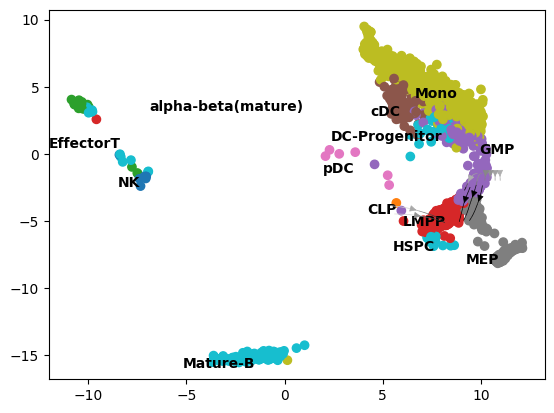

In [15]:
perturbation_over_iter = pickle.load(open('/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/SCENICPlus_Pipeline/AML/Perturbation/HOXA3_Perturbation.pkl', 'rb'))
fig, ax = plt.subplots()
plot_scenic_umap(ax)
plot_perturbation_effect_in_embedding(
    perturbed_matrix = perturbation_over_iter[10],
    original_matrix = perturbation_over_iter[0],
    embedding = eRegulon_gene_AUC.obsm["X_umap"][:, 0:2],
    AUC_kwargs = {},
    ax = ax,
    eRegulons = pd.concat(
        [
            scplus_mdata.uns["direct_e_regulon_metadata"],
            scplus_mdata.uns["extended_e_regulon_metadata"]
        ]
    ),
    n_cpu = 10
)

2024-11-19 22:41:01,823 Perturbation INFO     Generating ranking based on perturbed matrix.
2024-11-19 22:41:09,291 Perturbation INFO     Scoring eRegulons.
2024-11-19 22:41:27,155 Perturbation INFO     Projecting perturbation effect in embedding


/home/sussmanj/miniconda3/envs/scenicplus/lib/python3.11/site-packages/scenicplus/simulation.py:232: RuntimeWarning: invalid value encountered in divide


2024-11-19 22:43:44,071 Perturbation INFO     Calculating grid of arrows
2024-11-19 22:43:44,144 Perturbation INFO     Plotting


<AxesSubplot: >

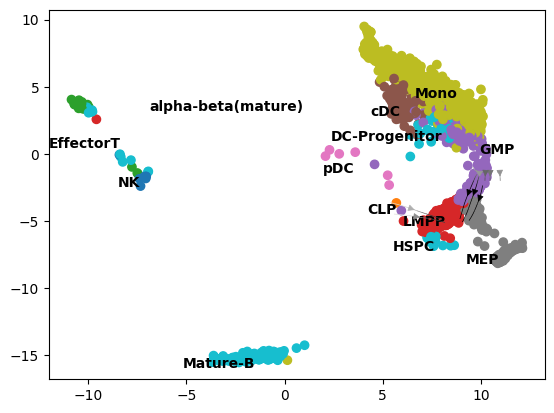

In [16]:
perturbation_over_iter = pickle.load(open('/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/SCENICPlus_Pipeline/AML/Perturbation/HOXA5_Perturbation.pkl', 'rb'))
fig, ax = plt.subplots()
plot_scenic_umap(ax)
plot_perturbation_effect_in_embedding(
    perturbed_matrix = perturbation_over_iter[10],
    original_matrix = perturbation_over_iter[0],
    embedding = eRegulon_gene_AUC.obsm["X_umap"][:, 0:2],
    AUC_kwargs = {},
    ax = ax,
    eRegulons = pd.concat(
        [
            scplus_mdata.uns["direct_e_regulon_metadata"],
            scplus_mdata.uns["extended_e_regulon_metadata"]
        ]
    ),
    n_cpu = 10
)

2024-11-19 22:44:05,054 Perturbation INFO     Generating ranking based on perturbed matrix.
2024-11-19 22:44:13,550 Perturbation INFO     Scoring eRegulons.
2024-11-19 22:44:31,585 Perturbation INFO     Projecting perturbation effect in embedding


/home/sussmanj/miniconda3/envs/scenicplus/lib/python3.11/site-packages/scenicplus/simulation.py:232: RuntimeWarning: invalid value encountered in divide


2024-11-19 22:46:50,769 Perturbation INFO     Calculating grid of arrows
2024-11-19 22:46:50,833 Perturbation INFO     Plotting


<AxesSubplot: >

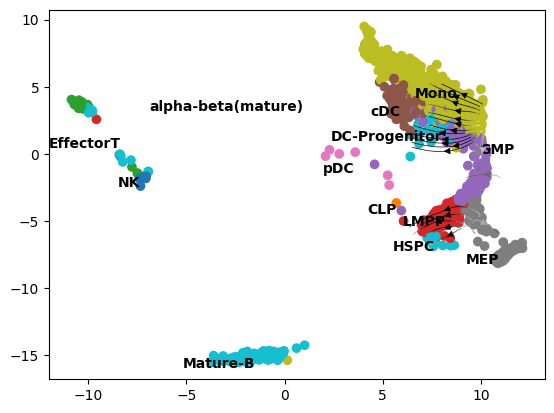

In [17]:
perturbation_over_iter = pickle.load(open('/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/SCENICPlus_Pipeline/AML/Perturbation/HOXA9_Perturbation.pkl', 'rb'))
fig, ax = plt.subplots()
plot_scenic_umap(ax)
plot_perturbation_effect_in_embedding(
    perturbed_matrix = perturbation_over_iter[10],
    original_matrix = perturbation_over_iter[0],
    embedding = eRegulon_gene_AUC.obsm["X_umap"][:, 0:2],
    AUC_kwargs = {},
    ax = ax,
    eRegulons = pd.concat(
        [
            scplus_mdata.uns["direct_e_regulon_metadata"],
            scplus_mdata.uns["extended_e_regulon_metadata"]
        ]
    ),
    n_cpu = 10
)

2024-11-19 22:47:39,828 Perturbation INFO     Generating ranking based on perturbed matrix.
2024-11-19 22:47:49,052 Perturbation INFO     Scoring eRegulons.
2024-11-19 22:48:04,787 Perturbation INFO     Projecting perturbation effect in embedding


/home/sussmanj/miniconda3/envs/scenicplus/lib/python3.11/site-packages/scenicplus/simulation.py:232: RuntimeWarning: invalid value encountered in divide


2024-11-19 22:50:38,892 Perturbation INFO     Calculating grid of arrows
2024-11-19 22:50:38,958 Perturbation INFO     Plotting


<AxesSubplot: >

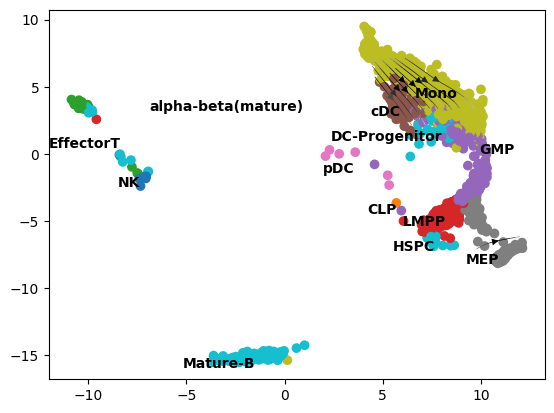

In [19]:
perturbation_over_iter = pickle.load(open('/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/SCENICPlus_Pipeline/AML/Perturbation/FOSB_Perturbation.pkl', 'rb'))
fig, ax = plt.subplots()
plot_scenic_umap(ax)
plot_perturbation_effect_in_embedding(
    perturbed_matrix = perturbation_over_iter[10],
    original_matrix = perturbation_over_iter[0],
    embedding = eRegulon_gene_AUC.obsm["X_umap"][:, 0:2],
    AUC_kwargs = {},
    ax = ax,
    eRegulons = pd.concat(
        [
            scplus_mdata.uns["direct_e_regulon_metadata"],
            scplus_mdata.uns["extended_e_regulon_metadata"]
        ]
    ),
    n_cpu = 10
)

2024-11-19 22:51:01,601 Perturbation INFO     Generating ranking based on perturbed matrix.
2024-11-19 22:51:34,083 Perturbation INFO     Scoring eRegulons.
2024-11-19 22:52:04,717 Perturbation INFO     Projecting perturbation effect in embedding


/home/sussmanj/miniconda3/envs/scenicplus/lib/python3.11/site-packages/scenicplus/simulation.py:232: RuntimeWarning: invalid value encountered in divide


2024-11-19 22:56:50,457 Perturbation INFO     Calculating grid of arrows
2024-11-19 22:56:51,037 Perturbation INFO     Plotting


<AxesSubplot: >

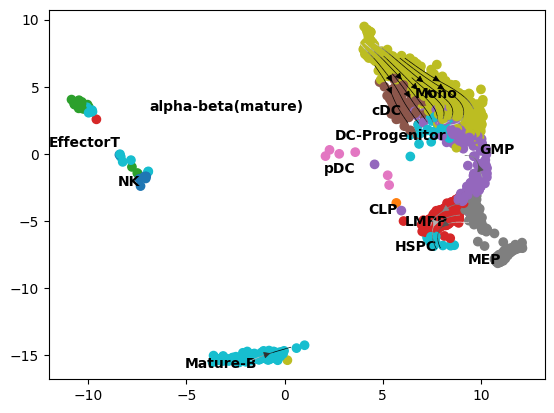

In [20]:
perturbation_over_iter = pickle.load(open('/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/SCENICPlus_Pipeline/AML/Perturbation/JUNB_Perturbation.pkl', 'rb'))
fig, ax = plt.subplots()
plot_scenic_umap(ax)
plot_perturbation_effect_in_embedding(
    perturbed_matrix = perturbation_over_iter[10],
    original_matrix = perturbation_over_iter[0],
    embedding = eRegulon_gene_AUC.obsm["X_umap"][:, 0:2],
    AUC_kwargs = {},
    ax = ax,
    eRegulons = pd.concat(
        [
            scplus_mdata.uns["direct_e_regulon_metadata"],
            scplus_mdata.uns["extended_e_regulon_metadata"]
        ]
    ),
    n_cpu = 10
)

2024-11-19 22:58:31,383 Perturbation INFO     Generating ranking based on perturbed matrix.
2024-11-19 22:58:54,523 Perturbation INFO     Scoring eRegulons.
2024-11-19 22:59:47,403 Perturbation INFO     Projecting perturbation effect in embedding


/home/sussmanj/miniconda3/envs/scenicplus/lib/python3.11/site-packages/scenicplus/simulation.py:232: RuntimeWarning: invalid value encountered in divide


2024-11-19 23:06:03,859 Perturbation INFO     Calculating grid of arrows
2024-11-19 23:06:04,024 Perturbation INFO     Plotting


<AxesSubplot: >

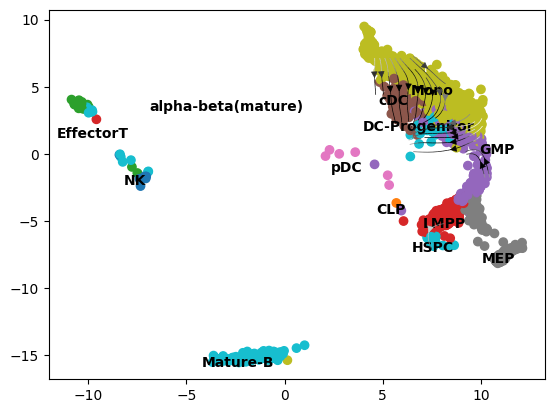

In [21]:
perturbation_over_iter = pickle.load(open('/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/SCENICPlus_Pipeline/AML/Perturbation/CEBPA_Perturbation.pkl', 'rb'))
fig, ax = plt.subplots()
plot_scenic_umap(ax)
plot_perturbation_effect_in_embedding(
    perturbed_matrix = perturbation_over_iter[10],
    original_matrix = perturbation_over_iter[0],
    embedding = eRegulon_gene_AUC.obsm["X_umap"][:, 0:2],
    AUC_kwargs = {},
    ax = ax,
    eRegulons = pd.concat(
        [
            scplus_mdata.uns["direct_e_regulon_metadata"],
            scplus_mdata.uns["extended_e_regulon_metadata"]
        ]
    ),
    n_cpu = 10
)

Individual Gene Perturbations

In [27]:
perturbation_over_iter = pickle.load(open('/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/SCENICPlus_Pipeline/AML/Perturbation/HOXA9_Perturbation.pkl', 'rb'))
df = perturbation_over_iter[11]
df.index = df.index.str.replace("___cisTopic", "", regex=False)
output_file = "/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/SCENICPlus_Pipeline/AML/Perturbation/AML_HOXA9_perturbation_iter_11_processed.tsv"
df.to_csv(output_file, sep="\t")
print(f"Processed file saved to {output_file}.")

perturbation_over_iter = pickle.load(open('/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/SCENICPlus_Pipeline/AML/Perturbation/HOXA5_Perturbation.pkl', 'rb'))
df = perturbation_over_iter[11]
df.index = df.index.str.replace("___cisTopic", "", regex=False)
output_file = "/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/SCENICPlus_Pipeline/AML/Perturbation/AML_HOXA5_perturbation_iter_11_processed.tsv"
df.to_csv(output_file, sep="\t")
print(f"Processed file saved to {output_file}.")

perturbation_over_iter = pickle.load(open('/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/SCENICPlus_Pipeline/AML/Perturbation/HOXA3_Perturbation.pkl', 'rb'))
df = perturbation_over_iter[11]
df.index = df.index.str.replace("___cisTopic", "", regex=False)
output_file = "/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/SCENICPlus_Pipeline/AML/Perturbation/AML_HOXA3_perturbation_iter_11_processed.tsv"
df.to_csv(output_file, sep="\t")
print(f"Processed file saved to {output_file}.")

perturbation_over_iter = pickle.load(open('/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/SCENICPlus_Pipeline/AML/Perturbation/JUNB_Perturbation.pkl', 'rb'))
df = perturbation_over_iter[11]
df.index = df.index.str.replace("___cisTopic", "", regex=False)
output_file = "/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/SCENICPlus_Pipeline/AML/Perturbation/AML_JUNB_perturbation_iter_11_processed.tsv"
df.to_csv(output_file, sep="\t")
print(f"Processed file saved to {output_file}.")

perturbation_over_iter = pickle.load(open('/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/SCENICPlus_Pipeline/AML/Perturbation/FOSB_Perturbation.pkl', 'rb'))
df = perturbation_over_iter[11]
df.index = df.index.str.replace("___cisTopic", "", regex=False)
output_file = "/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/SCENICPlus_Pipeline/AML/Perturbation/AML_FOSB_perturbation_iter_11_processed.tsv"
df.to_csv(output_file, sep="\t")
print(f"Processed file saved to {output_file}.")

perturbation_over_iter = pickle.load(open('/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/SCENICPlus_Pipeline/AML/Perturbation/CEBPA_Perturbation.pkl', 'rb'))
df = perturbation_over_iter[11]
df.index = df.index.str.replace("___cisTopic", "", regex=False)
output_file = "/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/SCENICPlus_Pipeline/AML/Perturbation/AML_CEBPA_perturbation_iter_11_processed.tsv"
df.to_csv(output_file, sep="\t")
print(f"Processed file saved to {output_file}.")


Processed file saved to /mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/SCENICPlus_Pipeline/AML/Perturbation/AML_HOXA9_perturbation_iter_11_processed.tsv.
Processed file saved to /mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/SCENICPlus_Pipeline/AML/Perturbation/AML_HOXA5_perturbation_iter_11_processed.tsv.
Processed file saved to /mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/SCENICPlus_Pipeline/AML/Perturbation/AML_HOXA3_perturbation_iter_11_processed.tsv.
Processed file saved to /mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/SCENICPlus_Pipeline/AML/Perturbation/AML_JUNB_perturbation_iter_11_processed.tsv.
Processed file saved to /mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/SCENICPlus_Pipeline/AML/Perturbation/AML_FOSB_perturbation_iter_11_processed.tsv.
Processed file saved to /mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/SCENICPlus_Pipeline/AML/Perturbation/AML_CEBPA_perturbation_iter_11_processed.tsv.


In [20]:
# Dictionary to store average values for each iteration
cd34_avg_values = {}

# Iterate over each iteration in the dictionary
for iter_num, df in perturbation_over_iter.items():
    if 'CD34' in df.columns:
        avg_value = df['SPINK2'].mean()  # Calculate the average
        cd34_avg_values[iter_num] = avg_value
    else:
        cd34_avg_values[iter_num] = None  # Mark as None if CD34 is not present

# Print the average values for each iteration
for iter_num, avg in cd34_avg_values.items():
    if avg is not None:
        print(f"Iteration {iter_num}: Average CD34 value = {avg}")
    else:
        print(f"Iteration {iter_num}: CD34 not present.")


Iteration 0: Average CD34 value = 0.37787148356437683
Iteration 1: Average CD34 value = 0.37787148356437683
Iteration 2: Average CD34 value = 0.37787148356437683
Iteration 3: Average CD34 value = 0.3808722200092455
Iteration 4: Average CD34 value = 0.3835765370815452
Iteration 5: Average CD34 value = 0.3808839788662485
Iteration 6: Average CD34 value = 0.3796740743379928
Iteration 7: Average CD34 value = 0.3759389387746938
Iteration 8: Average CD34 value = 0.3750430834396474
Iteration 9: Average CD34 value = 0.3744024867709868
Iteration 10: Average CD34 value = 0.3742067230751354
Iteration 11: Average CD34 value = 0.37386587323878395


In [21]:
counts = scplus_mdata["scRNA_counts"].to_df() 
counts['SPINK2'].mean()

0.37787148

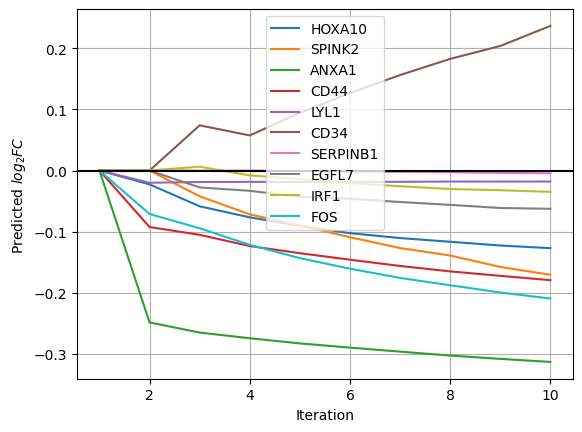

In [49]:
genes_to_show = ["HOXA10", "SPINK2", "ANXA1", "CD44", "LYL1", "CD34", "SERPINB1", "EGFL7", "IRF1", "FOS"]
cell_type = "Progenitor"
fig, ax = plt.subplots()
baseline = perturbation_over_iter[0].groupby(eRegulon_gene_AUC.obs["scRNA_counts:predicted.trajectory"]).mean().loc[cell_type, genes_to_show]
for gene in genes_to_show:
    ax.plot(
        np.arange(10) + 1,
        [
            np.log2(perturbation_over_iter[i].groupby(eRegulon_gene_AUC.obs["scRNA_counts:predicted.trajectory"]).mean().loc[cell_type, gene] / baseline[gene])
            for i in np.arange(10) + 1
        ],
        label = gene
    )
ax.set_ylabel("Predicted $log{_2}FC$")
ax.set_xlabel("Iteration")
ax.legend()
ax.axhline(y = 0, color = "black")
ax.grid("gray")
ax.set_axisbelow(True)